## Steps to set up your Release Pipeline:

Before going through these instructions, you should have the Service Principle Identity available and have the values for Tenant ID, Application ID and App Secret handy. If this is not prepared, make sure you complete the following instructions first:

### 0. Set up Service Principle Identity

The steps are provided here: https://docs.microsoft.com/en-us/azure/active-directory/develop/howto-create-service-principal-portal

Save the following pieces of information: Application ID, Tenant ID, Secret Key and replace them in the code below:

1. Create an Azure Active Directory application
1. Assign the application to a role
1. Get values for signing in
1. Certificates and secrets -> Create a new application secret

Now let's begin:

### 1. Use Azure DevOps’ Variable Groups to define the QA and Prod deployment parameters
In the Azure DevOps portal click on the Libraries, then create a  Variable Group. Within the Variable Group you need to provide:

**Name** = **Value**

app_secret = [you_app_secret]

application_id = [you_application_id]

subscription_id = [your_subscription_id]

tenant_id = [your_tenant_id]

workspace_name = [your_workspace_name]

workspace_region = [your_workspace_region]

aks_name = aks-deployment

aks_service_name_prod = mnist-webapp-service-prod

aks_service_name_qa = mnist-webapp-service-qa

cluster_name_cpu = cpucluster

cluster_name_gpu = gpucluster

cpu_compute_name = STANDARD_D2_V2

image_name = mnist-image-pipeline

model_name = tf_mnist_pipeline_devops.model

pipeline_experiment_name = MNIST-DevOps-Build

pipeline_name = MNIST-Pipeline-Built-From-Azure-DevOps

resource_group = AzureML

Image: 

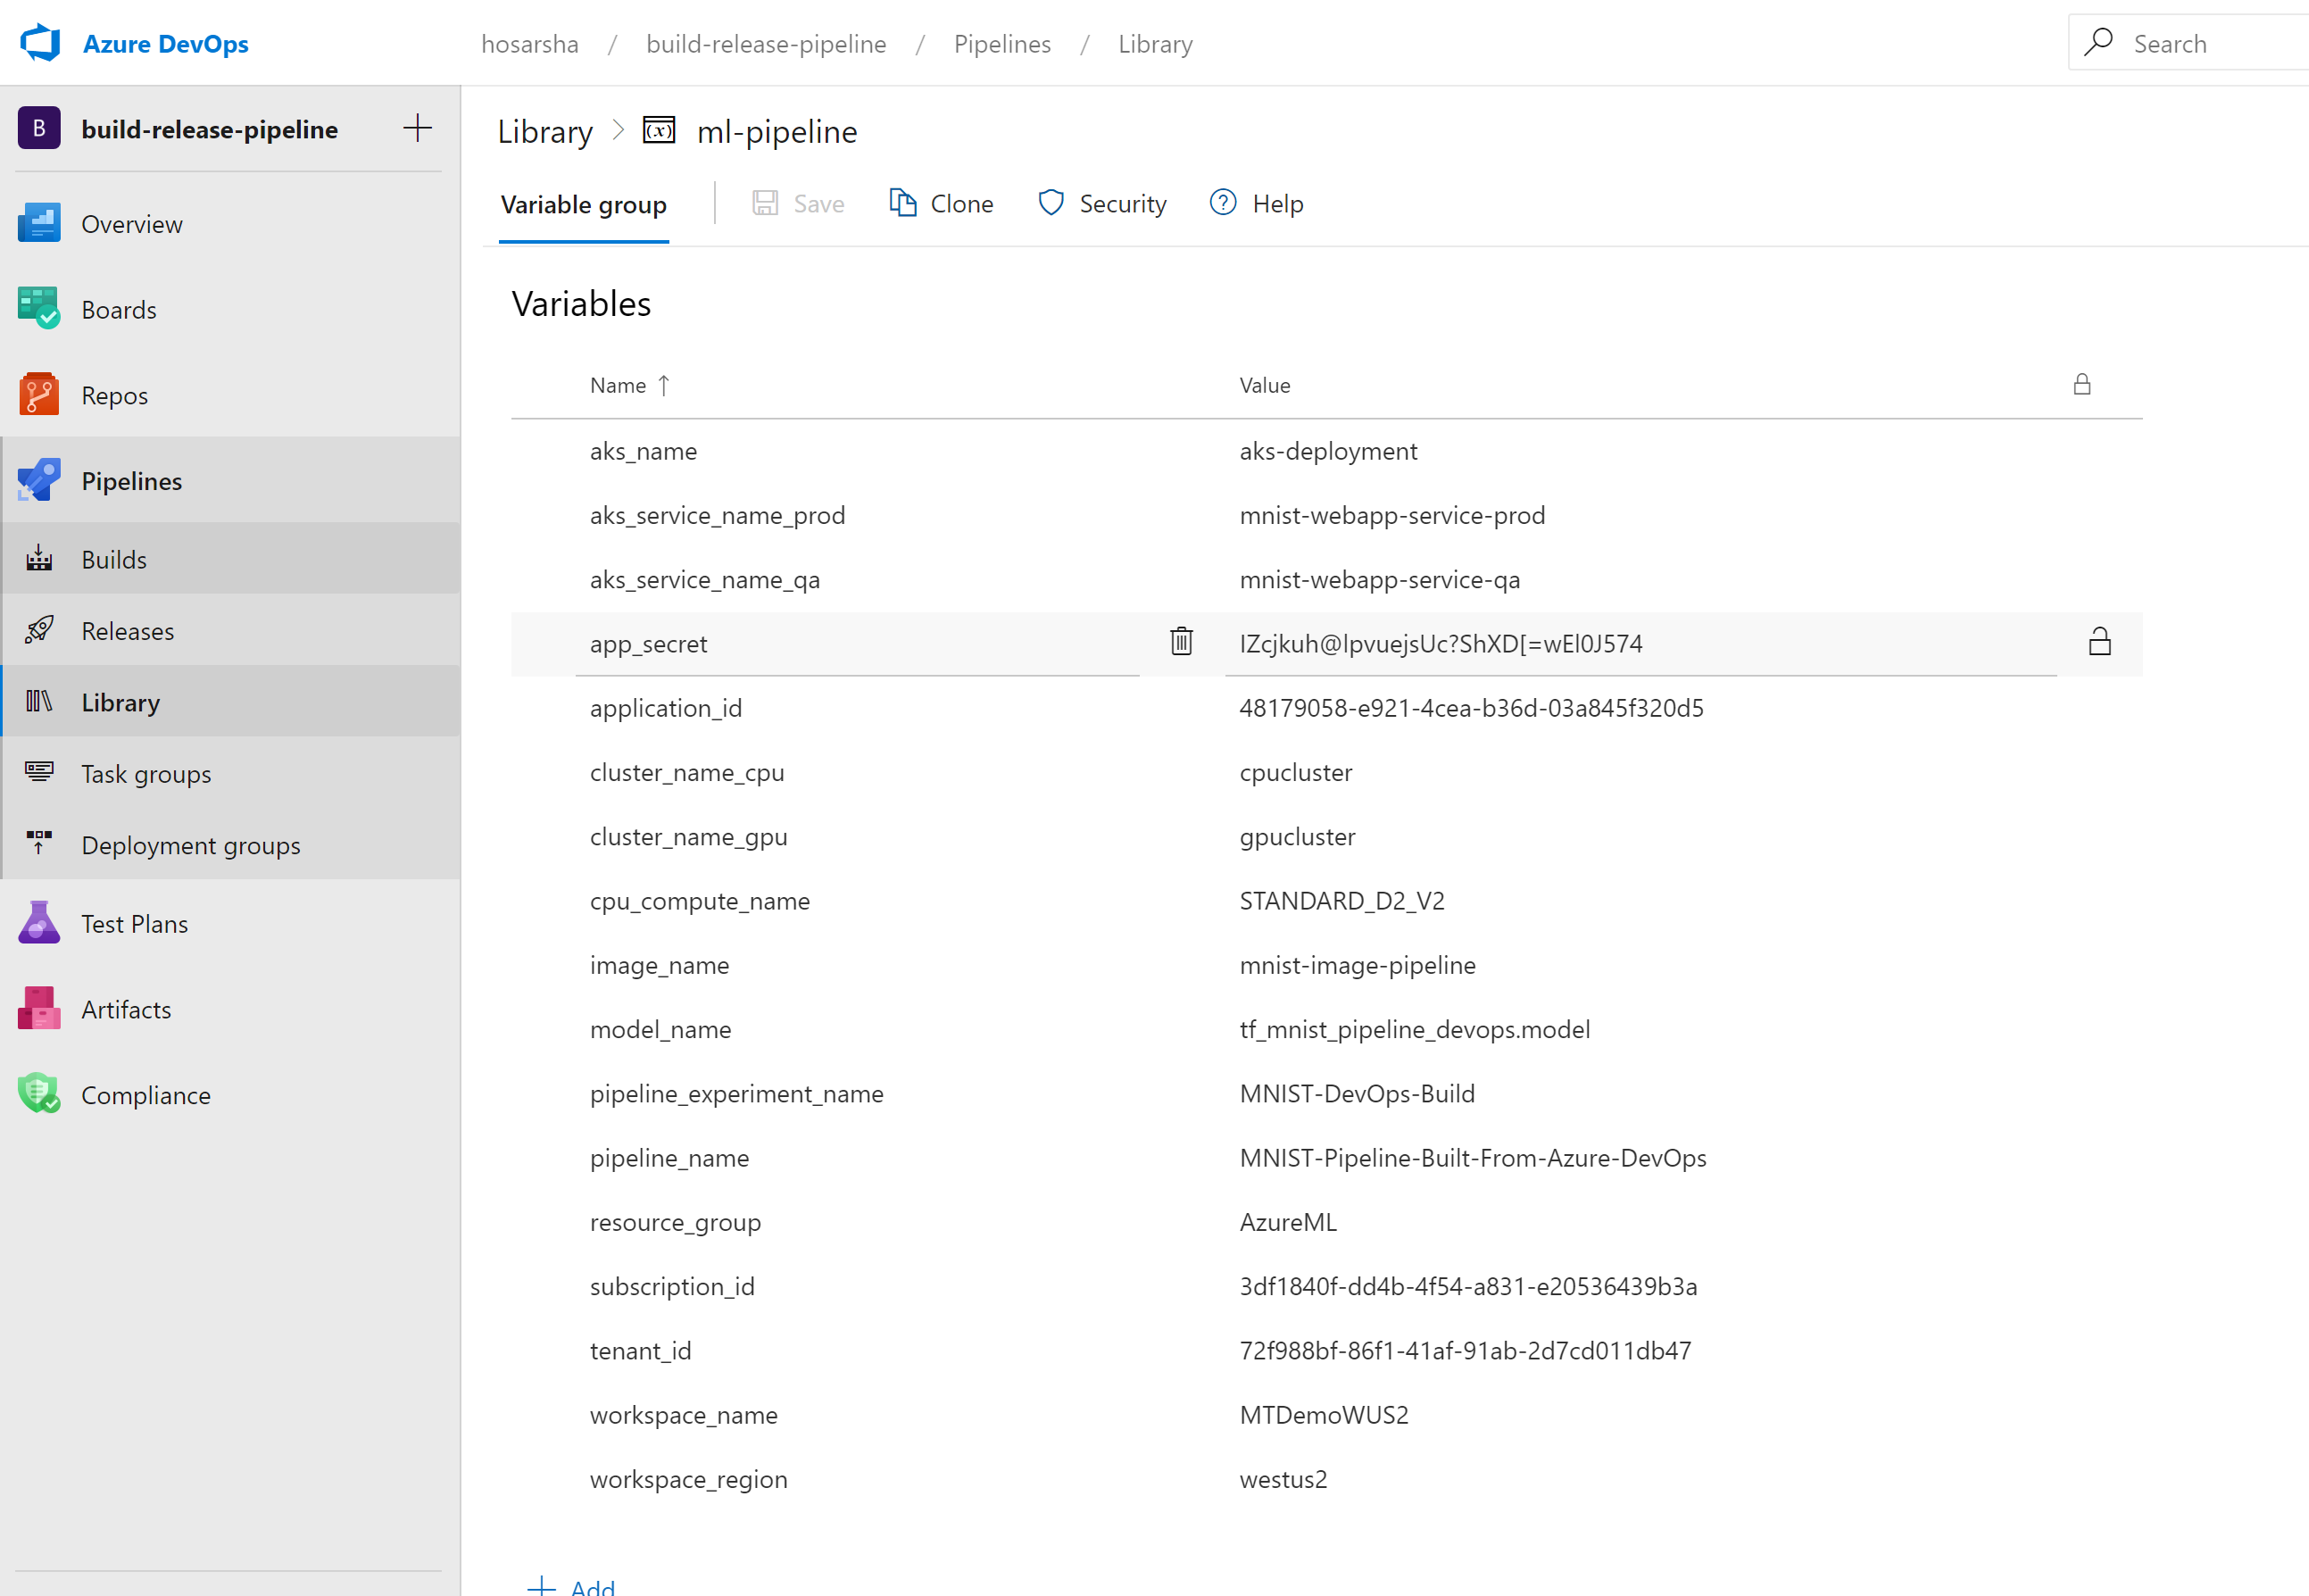

### 2. Modify the build steps:

Here are the steps for our Python Template:
1. Only leave Python 3.7 in the Variables section
1. In the Vatiables tab, click on the Variable Groups, click on Link Variable group. Select the Variable Group you created in the previous step.
1. In the Triggers, enable the CI.
1. Add a Use Python step
1. Add a command line, name it Install Dependencies, wihtin the text box add this:

```python -m pip install --upgrade pip && pip install -r requirements.txt```
1. Add a nother command line, name it pytest. Make sure the command is:

```pip install pytest && pytest tests --doctest-modules --junitxml=junit/test-results.xml```
1. Add publish test result
1. Add another command line, name it "Run, build and publish the ML Pipeline" and change the script to:

```python create-and-run-ml-pipeline.py  --tenant_id $(tenant_id) --application_id $(application_id) --app_secret $(app_secret) --subscription_id $(subscription_id) --resource_group $(resource_group) --workspace_name $(workspace_name) --workspace_region $(workspace_region) --model_name $(model_name) --cluster_name_cpu $(cluster_name_cpu) --cluster_name_gpu $(cluster_name_gpu) --pipeline_experiment_name $(pipeline_experiment_name) --pipeline_name $(pipeline_name)```
1. Add a copy files activity, name it Copy Files to: ```$(Build.ArtifactStagingDirectory)``` set:
Source Folder: ```$(Build.SourcesDirectory)```
**Contensts**: 

Score/**

TestDeployment/**

requirements_release.txt

**Target fodler**: ```$(Build.ArtifactStagingDirectory)```
1. Add a Publish build Artifact step, name it "Publish Artifact":
Path to publish: ```$(Build.ArtifactStagingDirectory)```
Artifact name: score-files
Artifact publish location: Azure Pipelines

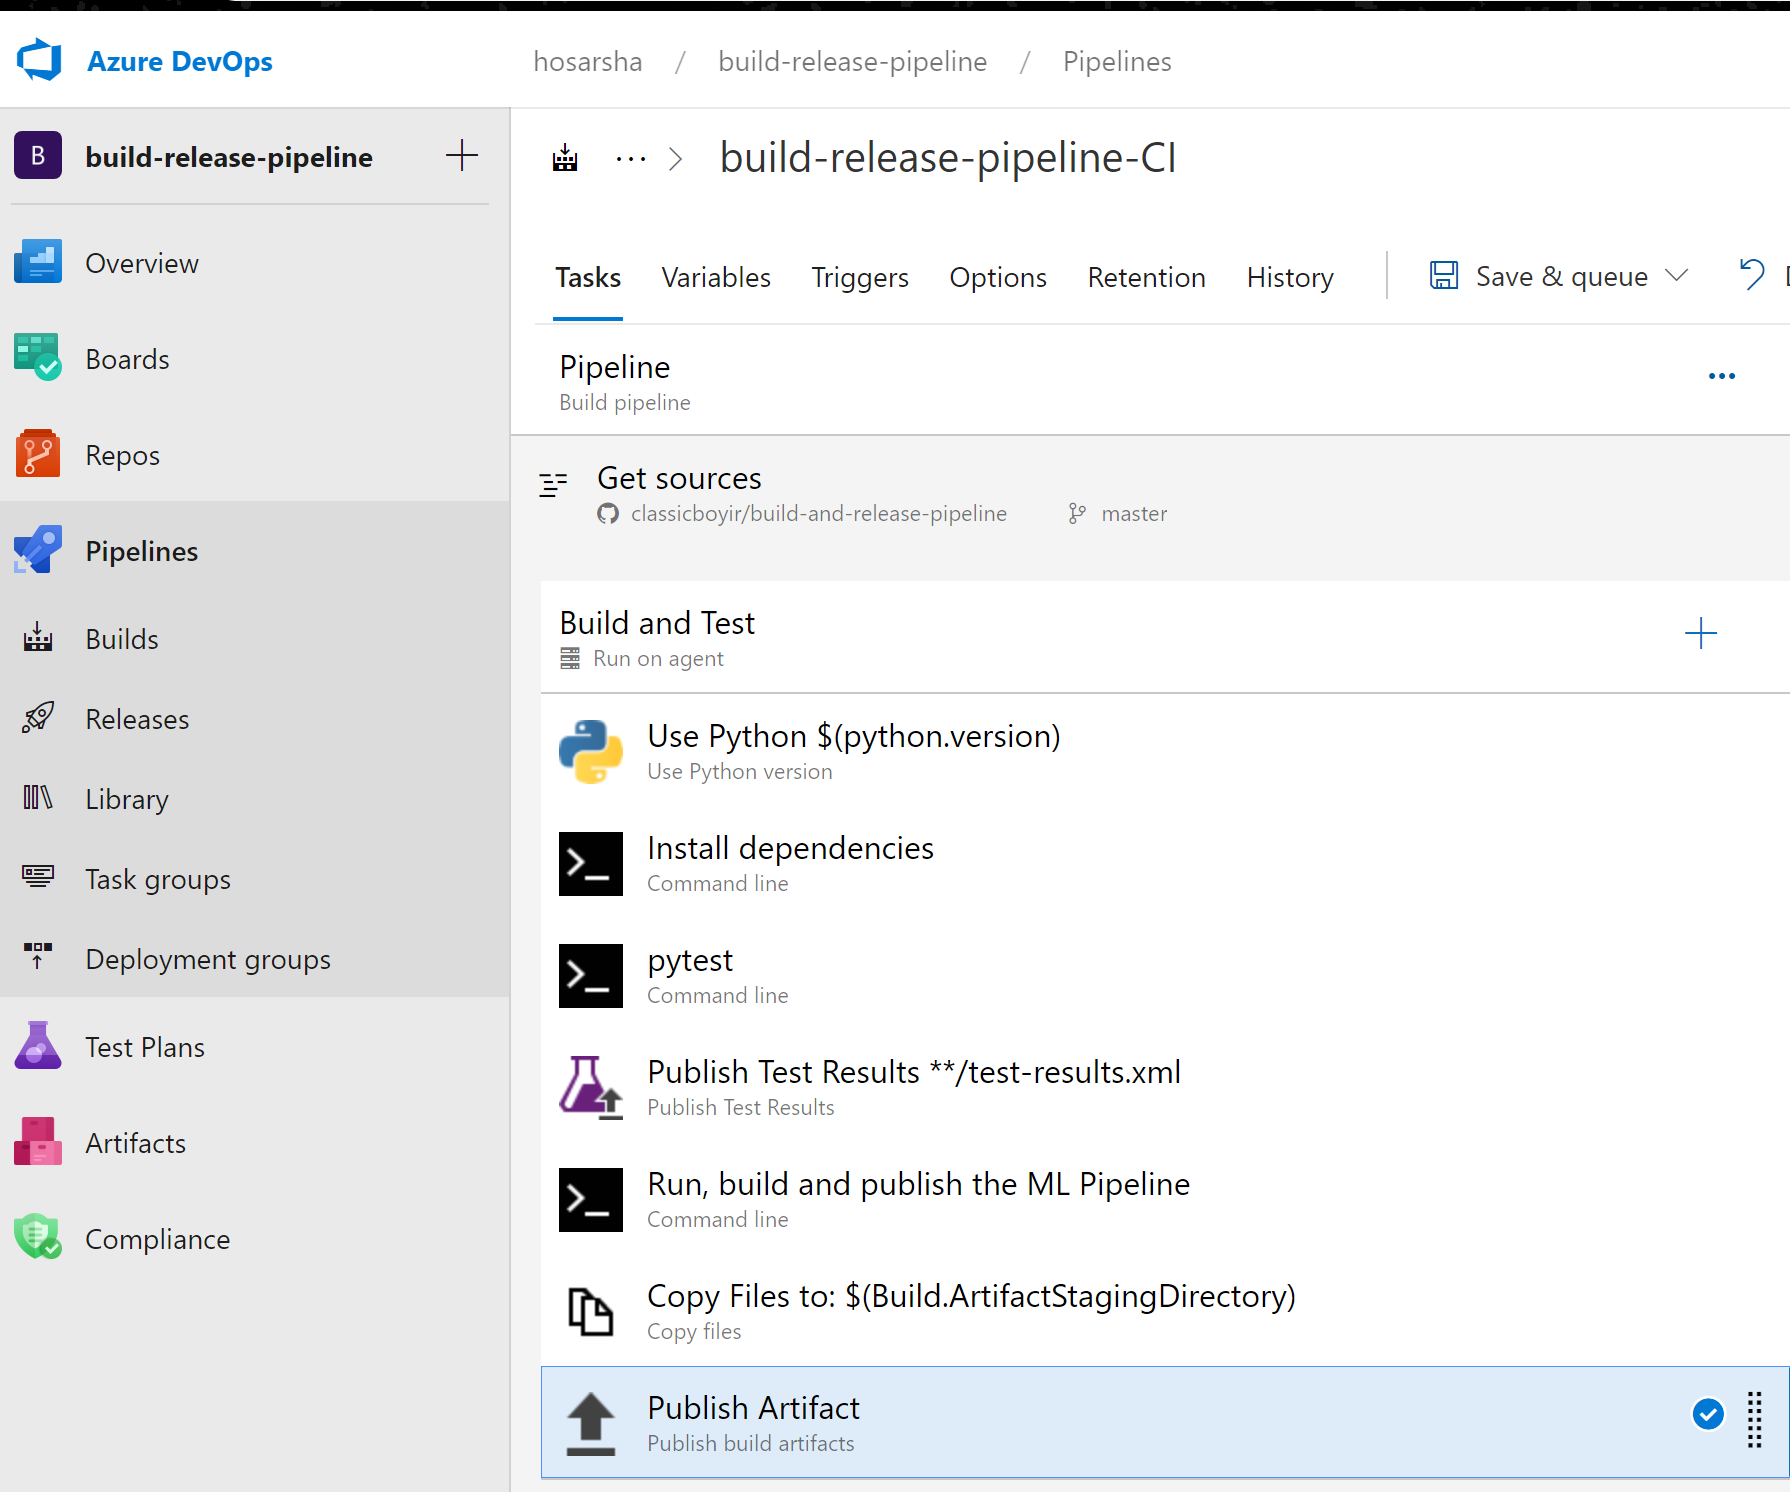

### 3. Save and Queue the Build Pipeline

### 4. Create Release Pipeline:

1. Install the Machine Learning Extension for Azure DevOps from: https://marketplace.visualstudio.com/items?itemName=ms-air-aiagility.vss-services-azureml
    1. Follow the instruction in the extension page to add a new Azure Resource Manager that is pointing to your ML Workspace
1. Click on the Releases from the Pipelines panel
1. Click on the Artifacts - Select the build pipeline and select the build artifact. Make sure you name it **_build-release-pipeline-CI** 
1. On the Artifact, add the Model using the Azure Resource Manager you registed earlier in 4.1
It should look like this:

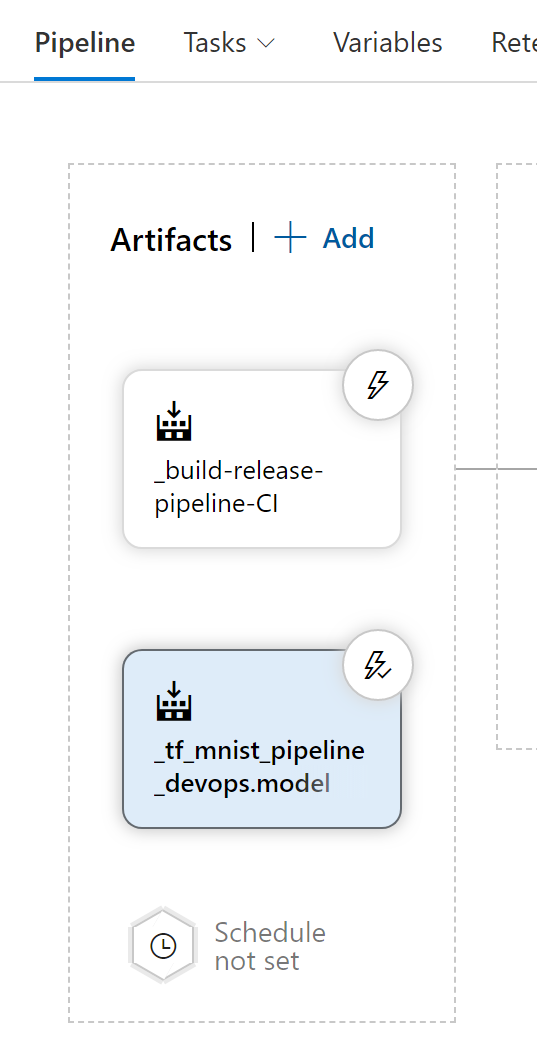

5. Add one stage, name it QA and provide the following steps:
    1. Click on the **1 job, 0 task**
    1. Click on the Task tab and provide the following steps:
    1. Use Python 3.7
    1. Add a command line step, name it: Install Dependencies and provide the following script:
    
    ```python -m pip install --upgrade pip && pip install -r $(System.DefaultWorkingDirectory)/_build-release-pipeline-CI/score-files/requirements_release.txt```
    1. Add another command line step, name it "Register the image and publish the image into AKS as QA web service" and for the script, provide:
    
    ```python $(System.DefaultWorkingDirectory)/_build-release-pipeline-CI/score-files/Score/deploy_model.py --script-root "$(System.DefaultWorkingDirectory)/_build-release-pipeline-CI/score-files"  --tenant_id $(tenant_id)  --application_id $(application_id)  --subscription_id $(subscription_id)  --app_secret $(app_secret)  --resource_group $(resource_group)  --workspace_name $(workspace_name)  --workspace_region $(workspace_region)  --model_name $(model_name)  --image_name $(image_name)  --aks_name $(aks_name)  --aks_service_name $(aks_service_name_qa)```
    
    1. Add the last step, for this add another command line, name it **Test the deployed model in QA** and for the script, provide:
    
    ```python $(System.DefaultWorkingDirectory)/_build-release-pipeline-CI/score-files/TestDeployment/model_test.py --script-root "$(System.DefaultWorkingDirectory)/_build-release-pipeline-CI/score-files/TestDeployment" --tenant_id $(tenant_id)  --application_id $(application_id)  --subscription_id $(subscription_id)  --app_secret $(app_secret)  --resource_group $(resource_group)  --workspace_name $(workspace_name)  --workspace_region $(workspace_region)  --aks_service_name $(aks_service_name_qa)```
    1. Click on the Variables tab, on Variables Group Link the **ml-pipeline** variable group that you created earlier. Make sure for the scope you select States (QA)
    
This stage should look like this:
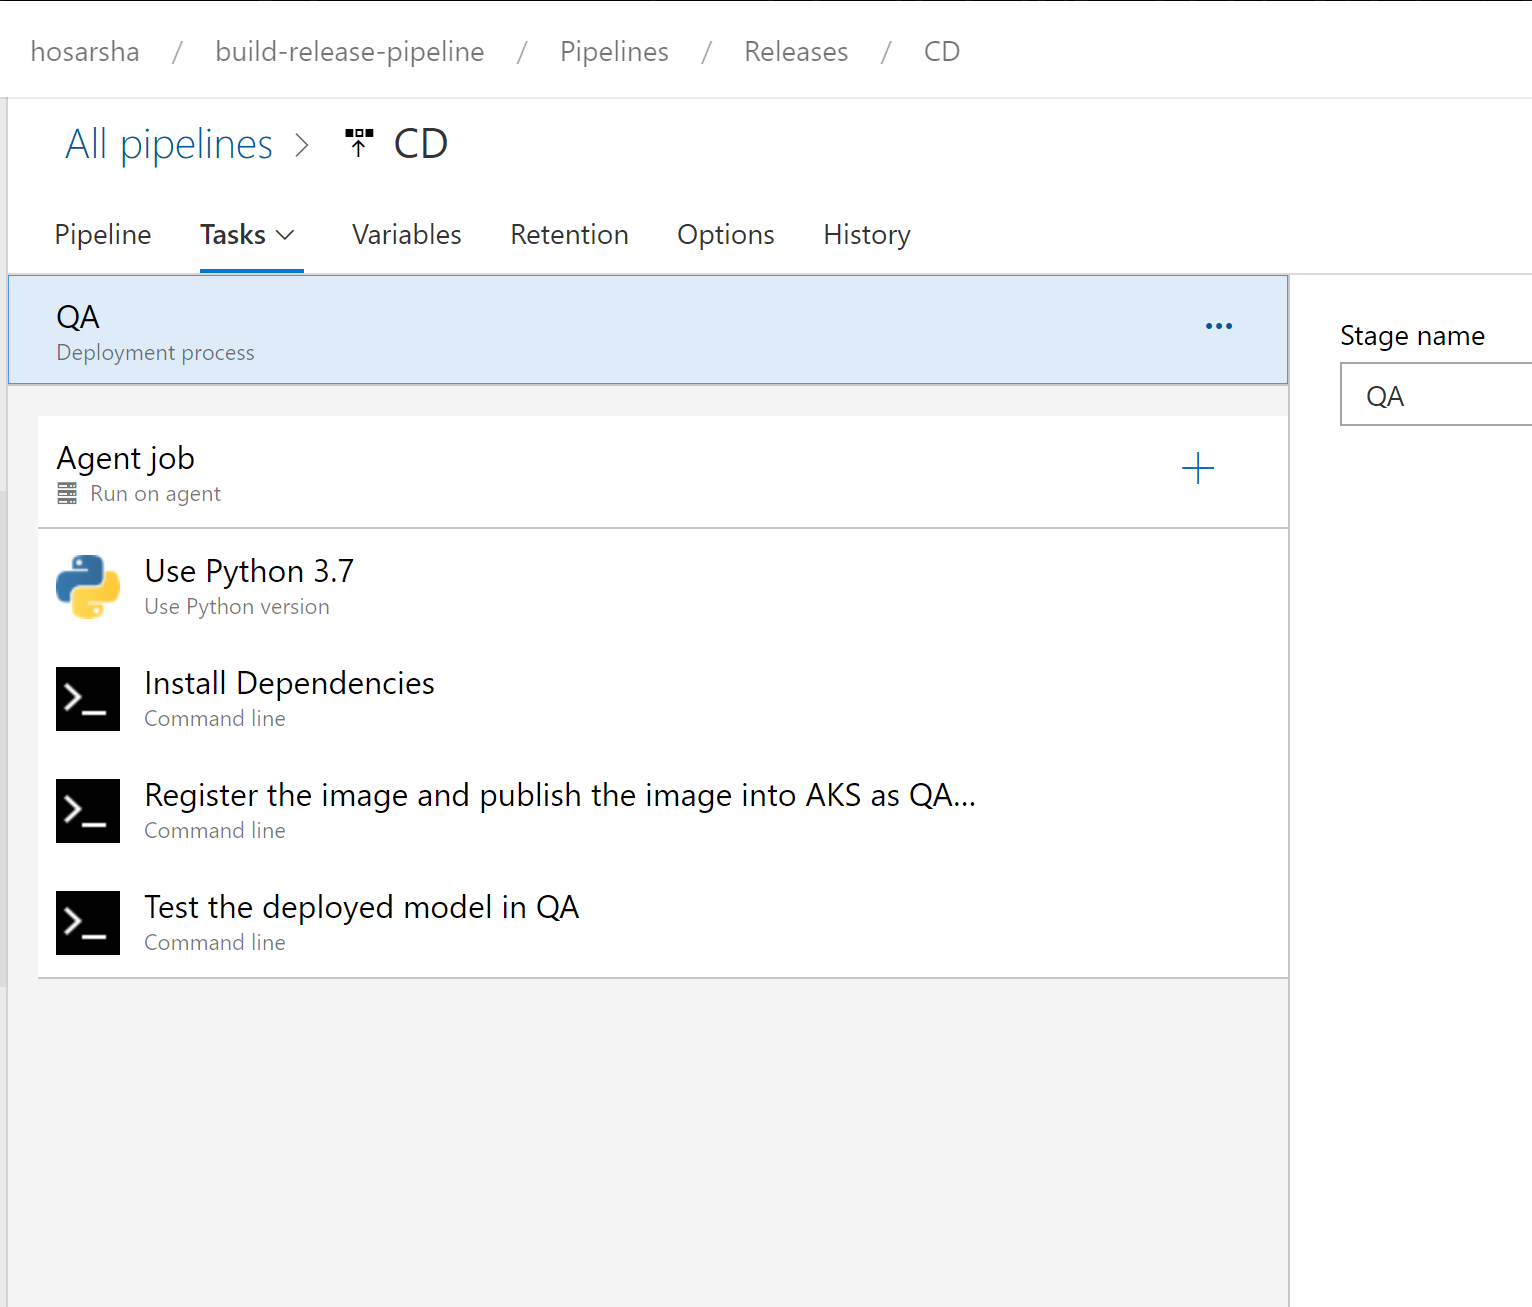

6. Click on the Pipeline
7. Hover on the QA Stage, then click on the Clone
8. Name it Prod then click on the **1 job, 4 tasks** and follow the below steps:
    1. Within the Tasks change the name of the 3rd task to: **Register the image and publish the image into AKS as Prod web service** and change the script to:
    
    ```python $(System.DefaultWorkingDirectory)/_build-release-pipeline-CI/score-files/Score/deploy_model.py --script-root "$(System.DefaultWorkingDirectory)/_build-release-pipeline-CI/score-files"  --tenant_id $(tenant_id)  --application_id $(application_id)  --subscription_id $(subscription_id)  --app_secret $(app_secret)  --resource_group $(resource_group)  --workspace_name $(workspace_name)  --workspace_region $(workspace_region)  --model_name $(model_name)  --image_name $(image_name)  --aks_name $(aks_name)  --aks_service_name $(aks_service_name_prod)```
    
    2. Change the name of the 4th step to: **Test the deployed model in Prod** and the script content to:
    
    ```python $(System.DefaultWorkingDirectory)/_build-release-pipeline-CI/score-files/TestDeployment/model_test.py --script-root "$(System.DefaultWorkingDirectory)/_build-release-pipeline-CI/score-files/TestDeployment" --tenant_id $(tenant_id)  --application_id $(application_id)  --subscription_id $(subscription_id)  --app_secret $(app_secret)  --resource_group $(resource_group)  --workspace_name $(workspace_name)  --workspace_region $(workspace_region)  --aks_service_name $(aks_service_name_prod)```
    
Now the steps look like this:
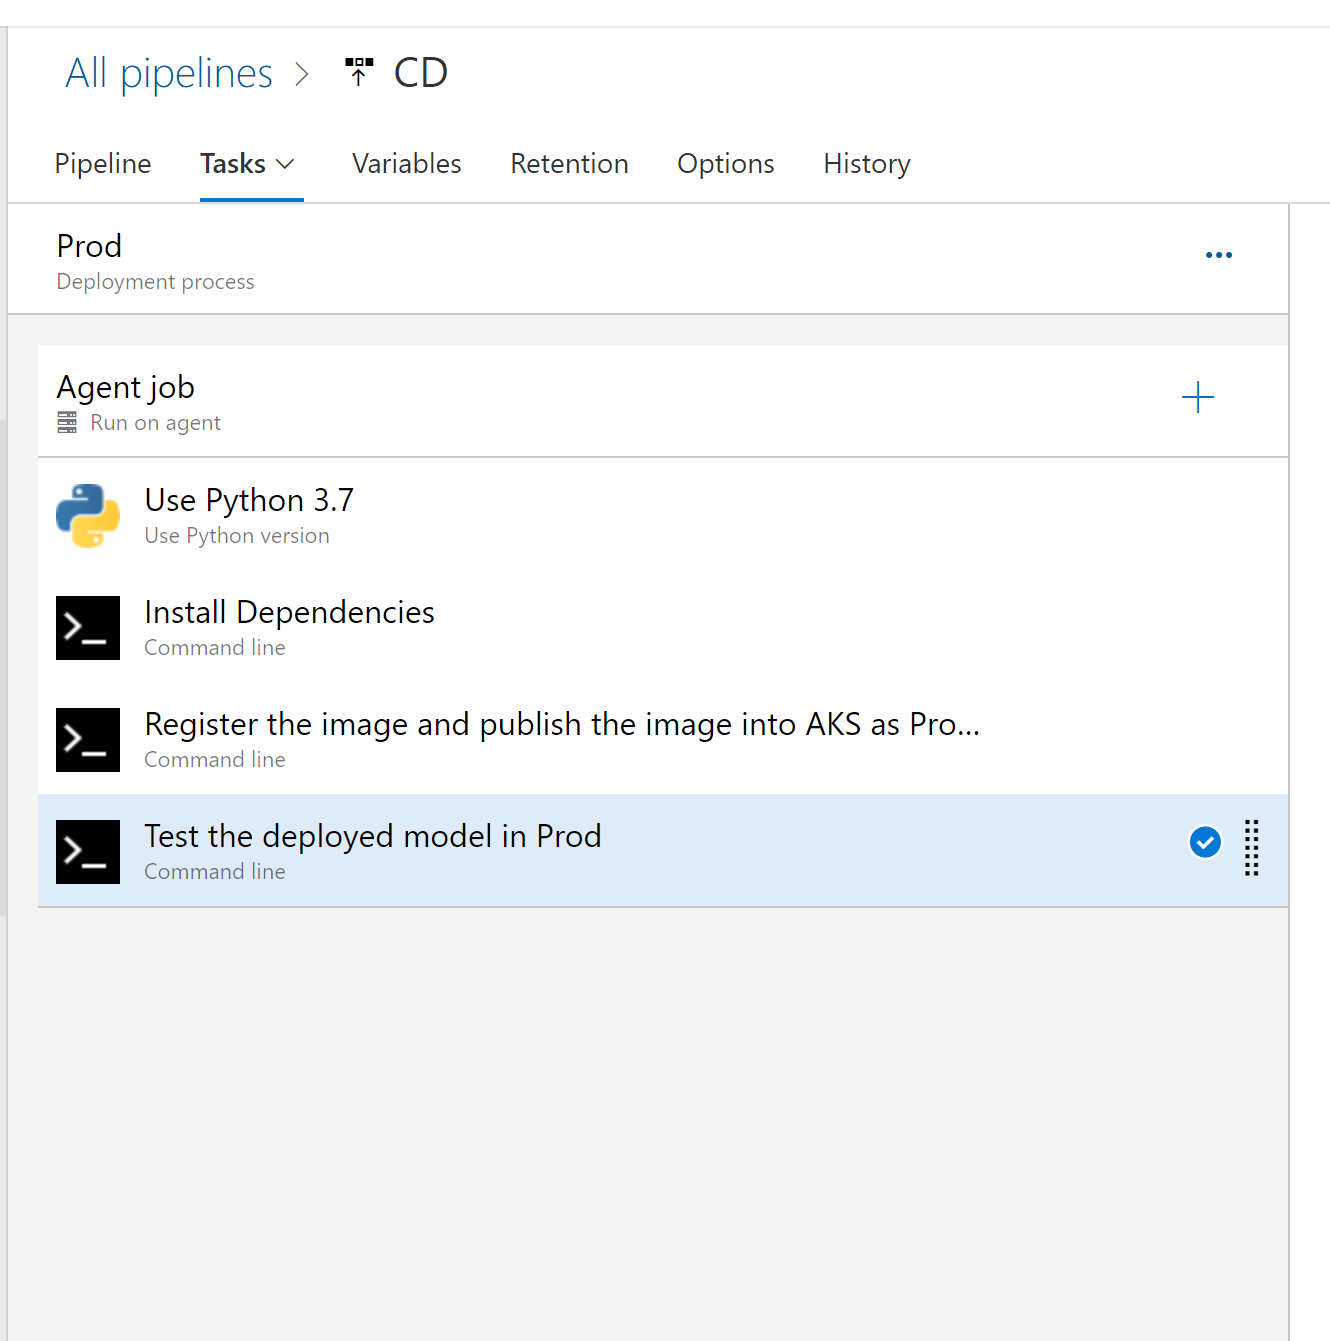

9. In the variables tab, make sure you see the QA and Prod in the scope:

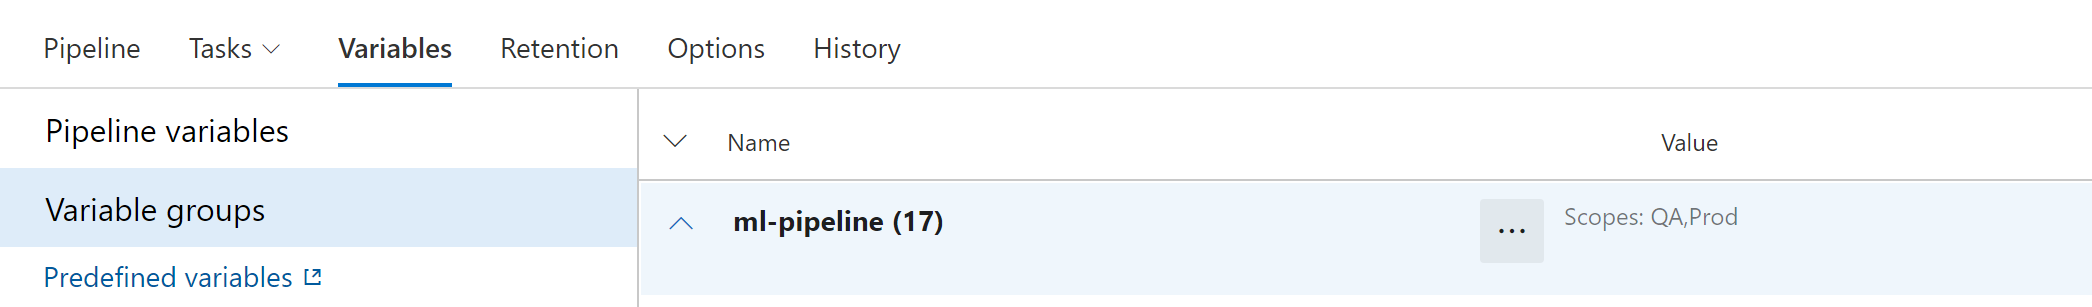

10. Click on the Pipeline tab, Click on the trigger toggle of the Model in the Asset Section, enable the CI.

This is how the final pipeline looks like:

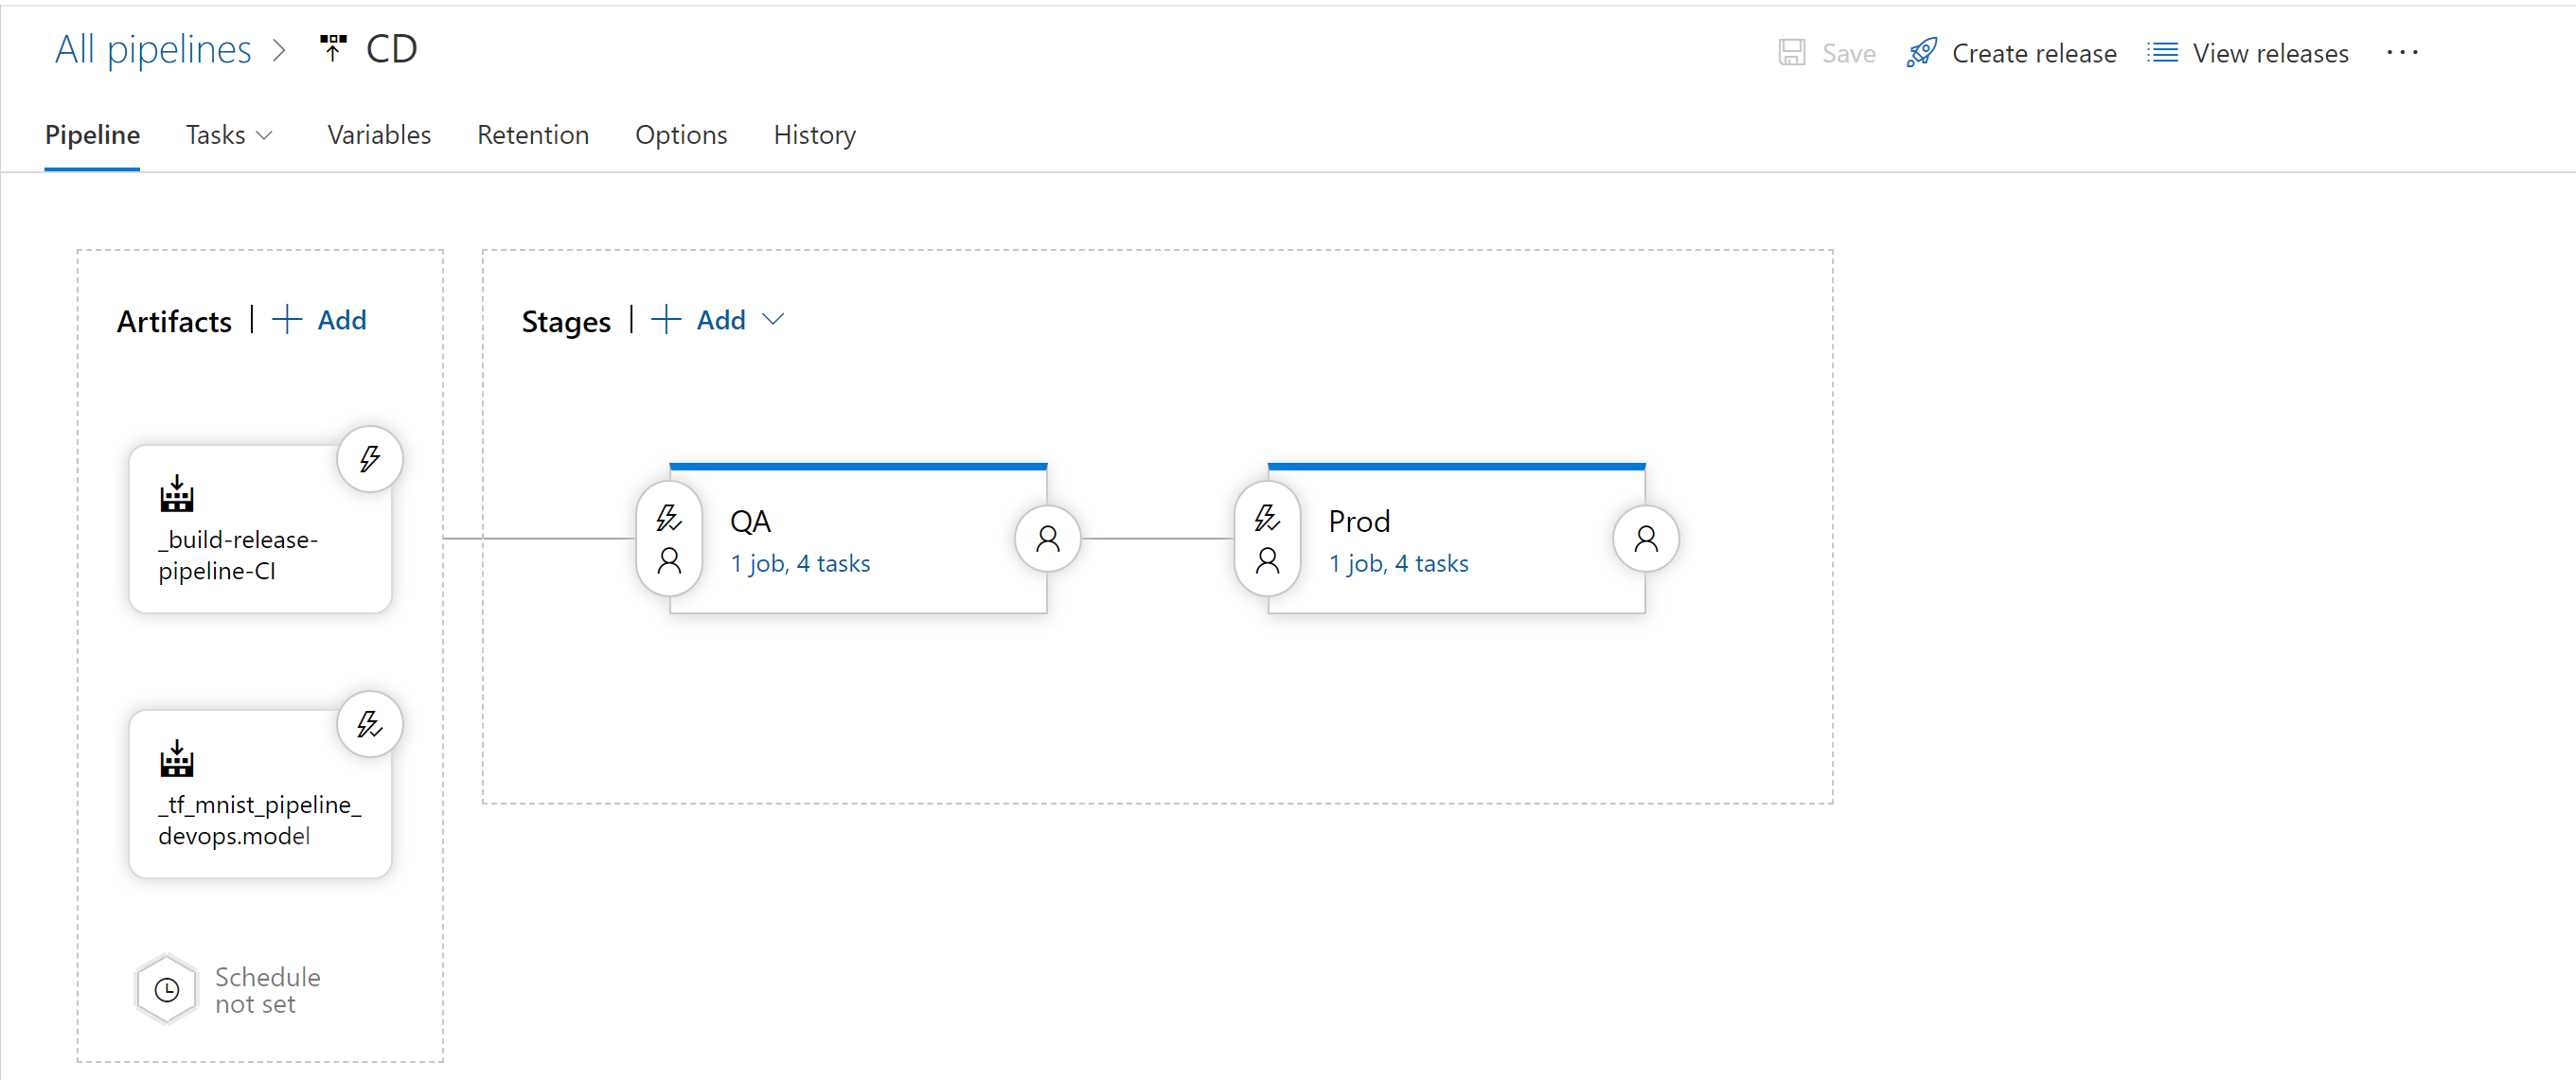

10. For the last step, click on the **Create release**

### What is next:

Now, once you push a new code into the repo, the build pipeline is kick off, then if a new model is added to the model registry, the release pipeline is click off, and finally, the model is deployed to the Kubernetes environment under two environment of QA and Prod.